## VGG16 
VGG 16 was proposed by Karen Simonyan and Andrew Zisserman of the Visual Geometry Group Lab of Oxford University in 2014 in the paper “VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION”. Also called VGGNet. It is a convolution neural network (CNN) model supporting 16 layers. 

In [1]:
# Import required packages
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed for reproducibility
tf.random.set_seed(42)

In [2]:
# Set the paths to train and valid folders
train_path = r'C:\Users\KIIT\PlantDatasetimages\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'
valid_path = r'C:\Users\KIIT\PlantDatasetimages\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid'

# Get list of all subfolders for each subset
train_dir = os.listdir(train_path)
valid_dir = os.listdir(valid_path)

print(len(train_dir), len(valid_dir))

38 38


In [3]:
# Set the image size and batch size
image_size = (224, 224)
batch_size = 32

In [4]:
# Create ImageDataGenerator instances with data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
# Load and preprocess the training dataset
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load and preprocess the validation dataset
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 56251 images belonging to 38 classes.
Found 3503 images belonging to 38 classes.


In [6]:
# Check the number of classes
num_classes = len(train_generator.class_indices)

In [7]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

In [8]:
# Create the new model architecture by adding the top layers
model_vgg16 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1]:
# Train the model and get training history
history_vgg16 = model_vgg16.fit(train_generator, epochs=60, validation_data=valid_generator)

NameError: name 'model_vgg16' is not defined

In [10]:
# Save the model
save_dir = r'C:\Users\KIIT\PlantDatasetimages'
save_path_vgg16 = os.path.join(save_dir, 'model_vgg16.h5')
model_vgg16.save(save_path_vgg16)

# Check if the model file exists
if os.path.exists(save_path_vgg16):
    print("Model saved successfully!")
else:
    print("Failed to save the model.")

Model saved successfully!


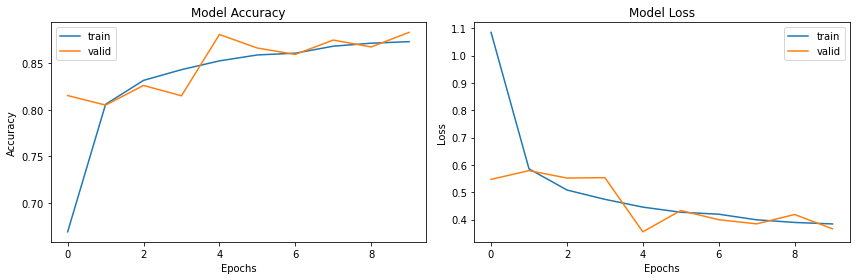

In [15]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def test_model(model_path, test_dir, download_output=False):
    # Load the trained model
    model = load_model(model_path)

    # Get the class labels from the training generator
    class_labels = list(train_generator.class_indices.keys())

    # Initialize lists to store the predicted labels and corresponding image paths
    predicted_labels = []
    image_paths = []

    # Iterate over the images in the test directory
    for image_file in os.listdir(test_dir):
        # Create the image file path
        image_path = os.path.join(test_dir, image_file)
        image_paths.append(image_path)

        # Load and preprocess the image
        image = load_img(image_path, target_size=image_size)
        image_array = img_to_array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        # Make predictions
        prediction = model.predict(image_array)
        predicted_label = class_labels[np.argmax(prediction)]
        predicted_labels.append(predicted_label)

        # Display the image with the predicted label
        plt.figure()
        plt.imshow(image)
        plt.title("Predicted Label: " + predicted_label)
        plt.axis('off')

    # Print the predicted labels and corresponding image paths in a tabular format
    print("Image\t\t\t\tPredicted Label")
    print("----------------------------------------------")
    for i in range(len(predicted_labels)):
        print(os.path.basename(image_paths[i]), "\t\t", predicted_labels[i])

    # Save the entire output as a single JPG image
    if download_output:
        output_image = Image.new('RGB', (600, 300 * len(predicted_labels)), color=(255, 255, 255))
        y_offset = 0
        for i in range(len(predicted_labels)):
            image = Image.open(image_paths[i])
            output_image.paste(image, (0, y_offset))
            draw = ImageDraw.Draw(output_image)
            draw.text((image.size[0] + 10, y_offset + 10), predicted_labels[i], fill=(0, 0, 0))
            y_offset += image.size[1] + 10
        output_image.save("output.jpg")

# Specify the path to the trained model and the test directory
model_path = r'C:\Users\KIIT\PlantDatasetimages\model_vgg16.h5'
test_directory = r'C:\Users\KIIT\PlantDatasetimages\test\test'

# Call the test_model function
test_model(model_path, test_directory, download_output=True)